## Coding Resources

**Notebook Inspiration 1:** https://colab.research.google.com/gist/alessandropaticchio/3d3b12c84c72ca15ede1c106c1e48572/feedback-prize-2021.ipynb#scrollTo=HyboiKthrb1O

**Notebook Inspiration 2:** https://colab.research.google.com/github/huggingface/notebooks/blob/9664c8b62e38083952b849da8912af13a35312b0/examples/accelerate/simple_nlp_example.ipynb#scrollTo=cJrsKX5AsnHp

## Load Required Packages & Tools...



In [ ]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 86.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
import nltk
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statistics

from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

In [ ]:
work_dir = '/content/drive/MyDrive/BMI_6330-Natural_Language_Processing/transformer_model/models/'

In [ ]:
#!pip install mendelai-brat-parser
#from brat_parser import get_entities_relations_attributes_groups

## Read in Training & Test Datasets...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

wdir = '/content/drive/MyDrive/BMI_6330-Natural_Language_Processing'

train = pd.read_csv(wdir+"/TRAIN.csv")
test = pd.read_csv(wdir+"/TEST.csv")

train.drop(labels="Unnamed: 0",axis=1, inplace=True)
test.drop(labels="Unnamed: 0",axis=1, inplace=True)

print('Number of Posts in Training Set: ' + str(len(train)) + " + Number of Posts in Test Set: " + str(len(test)))

Mounted at /content/drive
Number of Posts in Training Set: 1600 + Number of Posts in Test Set: 401


## Process/Format Data

In [ ]:
!pip install datasets

import datasets
from datasets import Dataset, DatasetDict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00


In [ ]:
ds_train = Dataset.from_pandas(train)
ds_test = Dataset.from_pandas(test)

ds = DatasetDict()

ds['train'] = ds_train
ds['test'] = ds_test

dataset = ds
dataset

DatasetDict({
    train: Dataset({
        features: ['ID', 'text', 'Non_Medical_Use', 'Withdrawl', 'Tolerance', 'Entities', 'Class', 'Start', 'End'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['ID', 'text', 'Non_Medical_Use', 'Withdrawl', 'Tolerance', 'Entities', 'Class', 'Start', 'End'],
        num_rows: 401
    })
})

## Allign Classes with Entitites & Tokenize

*   First, tokenize all posts into corresponding word pieces (these are given by coordinates where wordpiece1 goes from 0-3 in terms of position and is written as (0,3).
*   For each word piece (e.g (0,3) (3,6)...ect) determine if it is an entity or if it is just an unlabeled span of text
*   If the word piece is part of an entity, label it with the corresponding entity id (e.g no entity = 25 while ADHD = 0 and so on)
*   Returns the id associated with EACH word piece tokens (e.g if a post has 3 word piece tokens [(0,3),(3,6),(6,8)] then the function would determine which of them are part of a word piece: [25, 0, 25])

In [ ]:
classes_to_id = {
    'ADHD': 3,'Adderall': 1,'Anxiety': 3,'Caffeine': 2,'Vyvanse': 1,'Nicotine': 2,'Depression': 3,
    'Anti-Depressants': 2,'Eating_Disorder': 3,'Alcohol': 2,'OCD': 3,'Sleeping_Pills': 2,
    'Benzodiazepines': 2,'Antacids': 2,'Dexedrine': 1,'Focalin': 1,'Supplements': 2,
    'Bipolar': 3,'Ritalin': 1,'Concerta': 1,'Marijuana': 2,'Narcolepsy': 3,
    'Antipsychotic': 2,'Modafinil': 1,'WILD': 0, 'Prescription_Stimulants': 1}

In [ ]:
general_classes_to_id = {'WILD': 0, 'Perscription_Stimulants': 1, 'Substances': 2, 'Diagnoses': 3}

N_LABELS = len(general_classes_to_id)

id_to_classes = {0:'WILD', 1: 'Perscription_Stimulants', 2: 'Substances', 3: 'Diagnoses'}

In [ ]:
#model_ckpt = 'allenai/longformer-base-4096'
model_ckpt = 'distilbert/distilbert-base-uncased'
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

*   res['input_ids'][0] = the list of all integer values corresponding to the tokens in that given post (e.g [4,5,3,2] in ['hi', 'i', ''ve', 'changed'])
*   res['overflow_to_sample_mapping'] = gives the id of the original sentence (where the token belongs in the collection of documents if there are multiple sentences)
*   res['offset_mapping'][0] = the start and end position for a given token




In [ ]:
#MAX_LENGTH = 1024
MAX_LENGTH = 512
import ast
def labelling_tokens(sample):
  res = tokenizer(sample['text'], padding=True, return_offsets_mapping=True, truncation=True, max_length=MAX_LENGTH, return_overflowing_tokens=True)

  sample_mapping = res['overflow_to_sample_mapping']

  # maps each token to the chars in the string
  offset_mapping = res['offset_mapping']

  res["labels"] = []

  #print(sample_mapping)
  for i in range(len(offset_mapping)):
    s_index = sample_mapping[i]
    # Initialize labels array with WILD (ie no entity)
    labels = [classes_to_id["WILD"] for k in range(len(res['input_ids'][i]))] # number of tokens

    # label_start=start position of a given labeled entity (eg 499)
    # label_end=end position of a given labeled entity (eg 503)
    # label=name of the given entity (eg ADHD)
    # loops through each entity contained in the post...

    for label_start, label_end, label in list(zip(ast.literal_eval(sample['Start'][s_index]), ast.literal_eval(sample['End'][s_index]), ast.literal_eval(sample['Class'][s_index]))):

      for j in range(len(labels)):
        token_start = offset_mapping[i][j][0]
        token_end = offset_mapping[i][j][1]

        if token_start == label_start:
          labels[j] = classes_to_id[label]
        if int(token_start) > int(label_start) and int(token_end) <= int(label_end):
          labels[j] = classes_to_id[label]

    res['labels'].append(labels)

  return res

In [ ]:
tokenized_dataset = dataset.map(labelling_tokens, batched=True, batch_size=10000, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_dataset["train"])
print(tokenized_dataset["train"]['input_ids'][0:10])
print(tokenized_dataset["train"]['labels'][0:10])

Dataset({
    features: ['input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping', 'labels'],
    num_rows: 1600
})
[[0, 9226, 429, 2045, 101, 10, 15470, 618, 111, 53, 939, 348, 129, 57, 15, 5679, 29, 187, 6674, 6, 358, 34331, 57, 2051, 6, 8520, 5, 464, 11, 127, 301, 4, 959, 682, 939, 348, 5324, 939, 95, 33, 117, 773, 8, 818, 4157, 145, 15, 592, 433, 6, 42, 630, 75, 2369, 101, 10, 1099, 631, 4682, 939, 437, 10, 9463, 98, 5278, 16, 2008, 13, 127, 265, 4, 939, 202, 657, 127, 633, 8, 5, 2539, 939, 173, 19, 53, 939, 95, 4157, 608, 383, 101, 2851, 13010, 7, 1450, 73, 38177, 3443, 15, 592, 433, 73, 5350, 1295, 127, 4570, 4753, 2629, 7735, 142, 2052, 7, 127, 2329, 35905, 9726, 939, 21, 269, 205, 23, 9084, 17654, 6, 4412, 142, 939, 619, 101, 939, 21, 634, 24, 25, 10, 40965, 4190, 98, 939, 21, 460, 667, 7, 109, 357, 6, 120, 55, 4921, 4753, 122, 939, 64, 575, 540, 4, 8987, 8020, 114, 1268, 1493, 34, 2984, 42, 116, 939, 64, 75, 1341, 1137, 114, 42, 16, 31, 95, 145, 11, 10, 91

In [ ]:
#from sklearn.model_selection import train_test_split

#labels = tokenized_dataset['train']['labels']
#train_data, test_data = train_test_split(tokenized_dataset['train'], test_size=0.2, stratify=labels)

## **DONE DONT REDO**: Define Model, Perform Training, & Save Results



*   Use AutoModelForTokenClassification to predefine model as model_ckpt = 'allenai/longformer-base-4096'
*   Customize training options using TrainingArguments Class
*   Set up trainer object which requires model, training options, train/test sets, data collator and tokenizer as input
*   Use trainer object to train on data (5 epoch) and save the new model results to a file (work_dir+"modelV1")
*   Use trainer.predict() to make predictions on test set tokens


In [ ]:
general_classes_to_id = {'WILD': 0, 'Perscription_Stimulants': 1, 'Substances': 2, 'Diagnoses': 3}

id_to_classes = {0:'WILD', 1: 'Perscription_Stimulants', 2: 'Substances', 3: 'Diagnoses'}

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_ckpt, num_labels=N_LABELS, id2label=id_to_classes, label2id=general_classes_to_id) # where N_LABELS=9

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Some weights of LongformerForTokenClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Trainer Class** provides an API for feature-complete TRAINING in PyTorch and goes hand-in-hand with **Training Arguments Class** which offers options to customize HOW a model is trained.

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)

# CHANGE THE FIRST ARG TO THE RIGHT DIRECTORY!
args = TrainingArguments( # set up training parameters for the model
    model_ckpt + "_run",
    evaluation_strategy = "epoch", # how/whether/when to do evaluation which we specify to DO at the end of each EPOCH
    logging_strategy = "epoch", # do logging at the end of each epoch
    save_strategy = "epoch", # save is done at the end of each epoch
    learning_rate=1e-3,
    per_device_train_batch_size=4, # batch size per GPU
    per_device_eval_batch_size=4, # batch size per GPU for evaluation
    num_train_epochs=5,
)

In [ ]:
trainer = Trainer( # initialize trainer
    model, # AutoModelForTokenClassification
    args, # training options set up above
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator, # forms a batch using a list of dataset elements as input
    tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train() # train model

Input ids are automatically padded from 669 to 1024 to be a multiple of `config.attention_window`: 512


Epoch,Training Loss,Validation Loss
1,0.115100,0.090605
2,0.105900,0.097551
3,0.104100,0.086335
4,0.103200,0.089994
5,0.102500,0.091580


Input ids are automatically padded from 620 to 1024 to be a multiple of `config.attention_window`: 512


TrainOutput(global_step=2000, training_loss=0.10614533233642579, metrics={'train_runtime': 1161.7814, 'train_samples_per_second': 6.886, 'train_steps_per_second': 1.721, 'total_flos': 3414160299456000.0, 'train_loss': 0.10614533233642579, 'epoch': 5.0})

In [ ]:
trainer.save_model(work_dir+"modelV2_REDUCED_LONGFORM")

In [ ]:
predictions_logits = trainer.predict(tokenized_dataset["test"]) # predict on test set

NameError: name 'trainer' is not defined

In [ ]:
predictions_logits

PredictionOutput(predictions=array([[[-0.6625697 , -2.5216892 ,  1.1708152 , ..., -3.9800162 ,
         -3.7850857 ,  5.3982015 ],
        [-0.6625697 , -2.5216892 ,  1.1708152 , ..., -3.9800162 ,
         -3.7850862 ,  5.3982015 ],
        [-0.6625697 , -2.521689  ,  1.1708152 , ..., -3.9800162 ,
         -3.7850857 ,  5.3982015 ],
        ...,
        [-1.6573704 , -5.0142226 ,  1.1393721 , ..., -6.1517024 ,
         -5.5267105 ,  8.154919  ],
        [-1.6573704 , -5.0142226 ,  1.1393721 , ..., -6.1517024 ,
         -5.5267105 ,  8.154919  ],
        [-1.6573704 , -5.0142226 ,  1.1393721 , ..., -6.1517024 ,
         -5.5267105 ,  8.154919  ]],

       [[-0.6625697 , -2.5216892 ,  1.1708152 , ..., -3.9800162 ,
         -3.7850862 ,  5.3982015 ],
        [-0.66256976, -2.521689  ,  1.1708152 , ..., -3.9800162 ,
         -3.7850857 ,  5.3982015 ],
        [-0.6625697 , -2.5216892 ,  1.1708152 , ..., -3.9800162 ,
         -3.7850857 ,  5.3982015 ],
        ...,
        [-1.6573704 , -5.

In [ ]:
preds = np.argmax(predictions_logits.predictions, axis = -1)

In [ ]:
preds

array([[25, 25, 25, ..., 25, 25, 25],
       [25, 25, 25, ..., 25, 25, 25],
       [25, 25, 25, ..., 25, 25, 25],
       ...,
       [25, 25, 25, ..., 25, 25, 25],
       [25, 25, 25, ..., 25, 25, 25],
       [25, 25, 25, ..., 25, 25, 25]])

## Visualize Model and Evaluate Results

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(work_dir+"modelV2_REDUCED_LONGFORM", num_labels=N_LABELS)

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)
# CHANGE THE FIRST ARG TO THE RIGHT DIRECTORY!
args = TrainingArguments( # set up training parameters for the model
    model_ckpt + "_run",
    evaluation_strategy = "epoch", # how/whether/when to do evaluation which we specify to DO at the end of each EPOCH
    logging_strategy = "epoch", # do logging at the end of each epoch
    save_strategy = "epoch", # save is done at the end of each epoch
    learning_rate=1e-3,
    per_device_train_batch_size=4, # batch size per GPU
    per_device_eval_batch_size=4, # batch size per GPU for evaluation
    num_train_epochs=5,
)

In [ ]:
trainer = Trainer( # initialize trainer
    model, # AutoModelForTokenClassification
    args, # training options set up above
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator, # forms a batch using a list of dataset elements as input
    tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
gold_labels = np.array(tokenized_dataset["test"]["labels"]) # convert list of lists to np.array
gold_labels.shape

(401, 620)

In [ ]:
# I believe this gives class probabilities...
predictions_logits = trainer.predict(tokenized_dataset["test"]) # predict on test set

# get the most likely prediction for all token labels
predicted_labels = np.argmax(predictions_logits.predictions,axis=-1)
predicted_labels.shape

(401, 620)

In [ ]:
set(gold_labels[5])

{0}

In [ ]:
set(predicted_labels[5])

{0}

In [ ]:
from torch.nn.functional import softmax
import torch

logits = predictions_logits.predictions
probabilities = softmax(torch.tensor(logits), dim=1)
probabilities.shape

torch.Size([401, 620, 4])

In [ ]:
# flatten arrays to get single list of predictions for all samples
gold_flat = gold_labels.flatten()
test_flat = predicted_labels.flatten()

In [ ]:
from sklearn.metrics import classification_report

classification_report(gold_flat, test_flat)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       0.98      1.00      0.99    244861\n           1       0.00      0.00      0.00      3278\n           2       0.00      0.00      0.00       248\n           3       0.00      0.00      0.00       233\n\n    accuracy                           0.98    248620\n   macro avg       0.25      0.25      0.25    248620\nweighted avg       0.97      0.98      0.98    248620\n'

In [ ]:
# Compute overall accuracy
overall_accuracy = accuracy_score(gold_flat, test_flat)

# Compute accuracy for each class
class_accuracies = {}
for class_label in range(N_LABELS):
    # Extract indices corresponding to the current class
    indices = [i for i, label in enumerate(gold_flat) if label == class_label]

    # Extract true labels and predicted labels for the current class
    class_y_true = [gold_flat[i] for i in indices]
    class_y_pred = [test_flat[i] for i in indices]

    # Compute accuracy for the current class
    class_accuracy = accuracy_score(class_y_true, class_y_pred)

    # Store the accuracy for the current class
    class_accuracies[class_label] = class_accuracy

# Print overall accuracy and class-wise accuracies
print("Overall Accuracy:", overall_accuracy)
print("Class-wise Accuracies:")
for class_label, accuracy in class_accuracies.items():
    print(f"Class {class_label}: {accuracy}")

Overall Accuracy: 0.9848805405840239
Class-wise Accuracies:
Class 0: 1.0
Class 1: 0.0
Class 2: 0.0
Class 3: 0.0


In [ ]:
accuracy = accuracy_score(gold_flat, test_flat) # calculate accuracy

precision = precision_score(gold_flat, test_flat, average='weighted')
recall = recall_score(gold_flat, test_flat, average='weighted')
f1 = f1_score(gold_flat, test_flat, average='weighted')

# Calculate AUROC and AUPRC
# Binarize multiclass predictions because AUROC and AUPRC require binary classification!!!
# One-vs-Rest strategy can be used here

# np.eye creates a matrix of zeros (except for the diagonal=1) with 26 rows
# each row represents a different entity
gold_binarized = np.eye(4)[gold_flat]  # One-hot encode the true labels
test_scores = np.eye(4)[test_flat]  # One-hot encode the predicted labels
roc_auc = roc_auc_score(gold_binarized, test_scores, average='macro', multi_class='ovr')
auprc = average_precision_score(gold_binarized, test_scores, average='macro')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUROC:", roc_auc)
print("AUPRC:", auprc)


Accuracy: 0.9874710648148148
Precision: 0.984545171914607
Recall: 0.9874710648148148
F1-score: 0.9856659766943012
AUROC: 0.6529428984834496
AUPRC: 0.392595348869611


In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUROC', 'AUPRC']
values = [accuracy, precision, recall, f1, roc_auc, auprc]

<ipython-input-49-ac774043de9f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=values, y=metrics, palette="viridis")


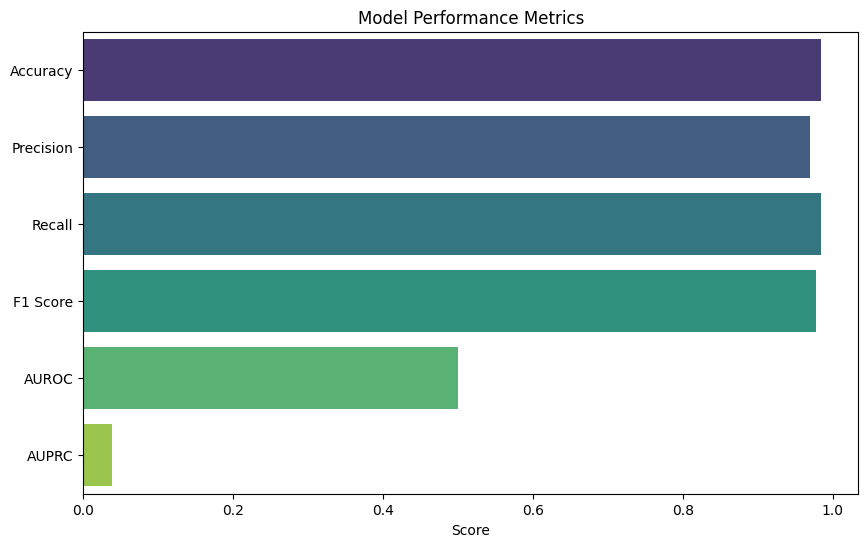

In [ ]:
# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=values, y=metrics, palette="viridis")
plt.xlabel('Score')
plt.title('Model Performance Metrics')
plt.show()

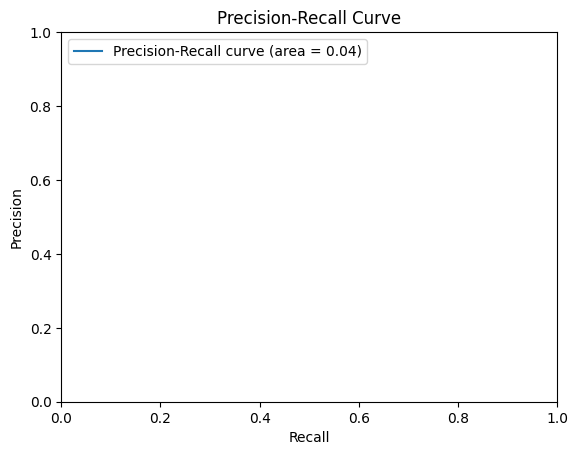

In [ ]:
# Plot Precision-Recall Curve
# Assuming you have computed precision and recall
#plt.figure(figsize=(8, 8))
plt.plot(recall, precision, label='Precision-Recall curve (area = %0.2f)' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1])
plt.xlim([0.0, 1])
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [ ]:
precision

0.969989679221079